In [1]:
!pip install yfinance numpy scipy matplotlib pennylane tensorflow-quantum


In [2]:
dir()  # or globals()


['In',
 'Out',
 '_',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_exit_code',
 '_i',
 '_i1',
 '_i2',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'exit',
 'get_ipython',
 'quit']

In [3]:
def get_risk_free_rate():
      return 0.03  # Example 3% risk-free rate

<ipython-input-4-1c860c21cd79>:12: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-4-1c860c21cd79>:25: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-4-1c860c21cd79>:29: RuntimeWarning: invalid value encountered in scalar divide
  gamma = norm.pdf(d1) / (S0 * sigma * np.sqrt(T))
<ipython-input-4-1c860c21cd79>:31: RuntimeWarning: invalid value encountered in scalar divide
  theta = -(S0 * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
<ipython-input-4-1c860c21cd79>:12: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-4-1c860c21cd79>:25: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma *

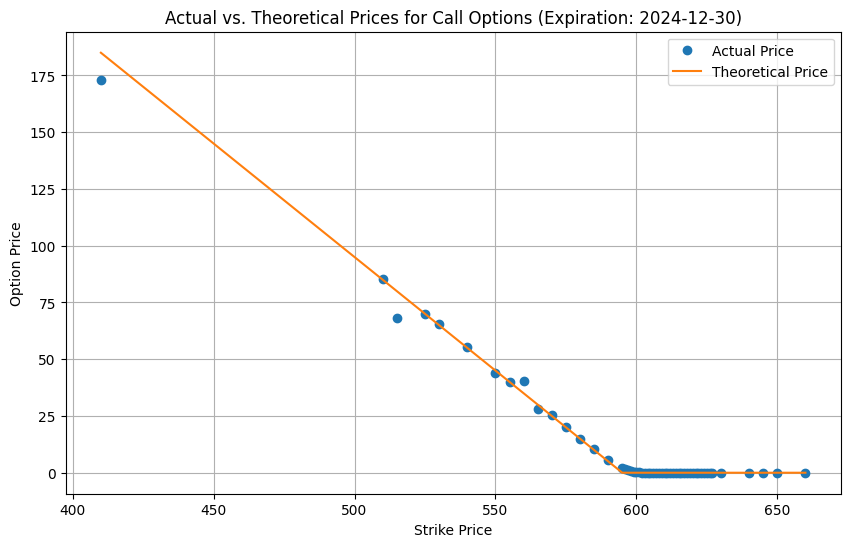

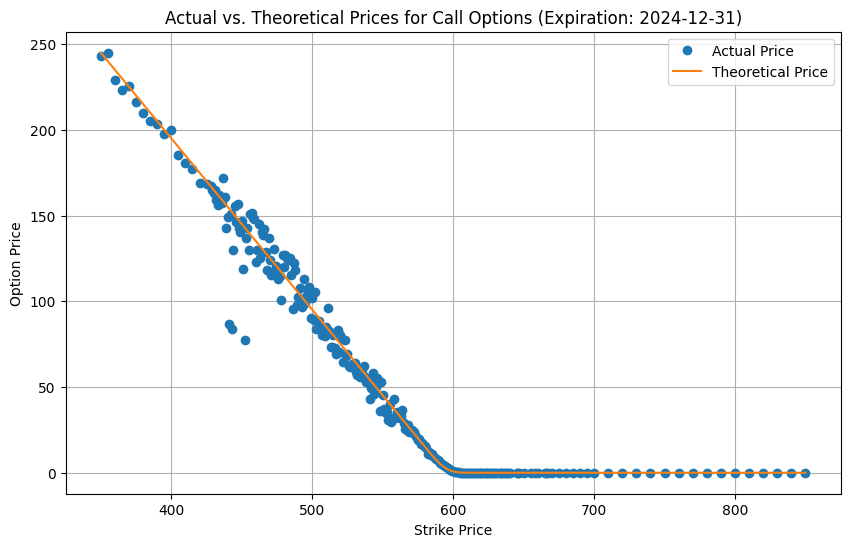

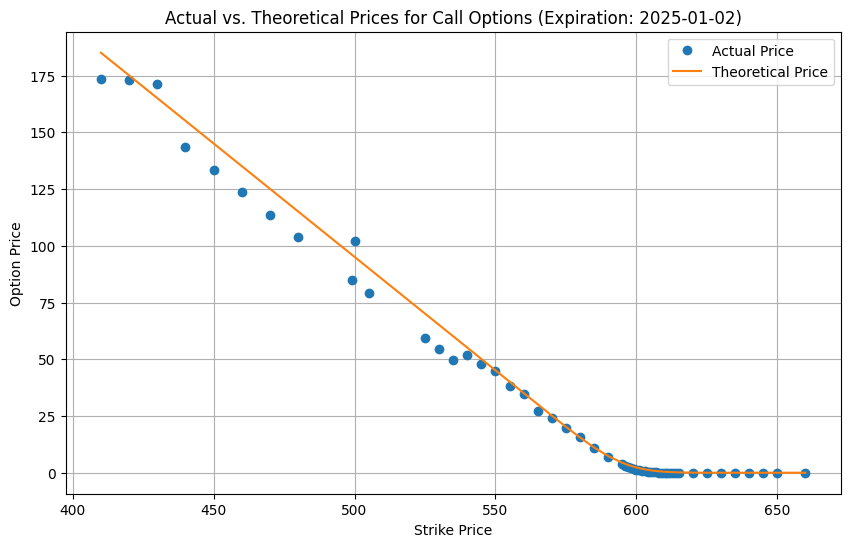

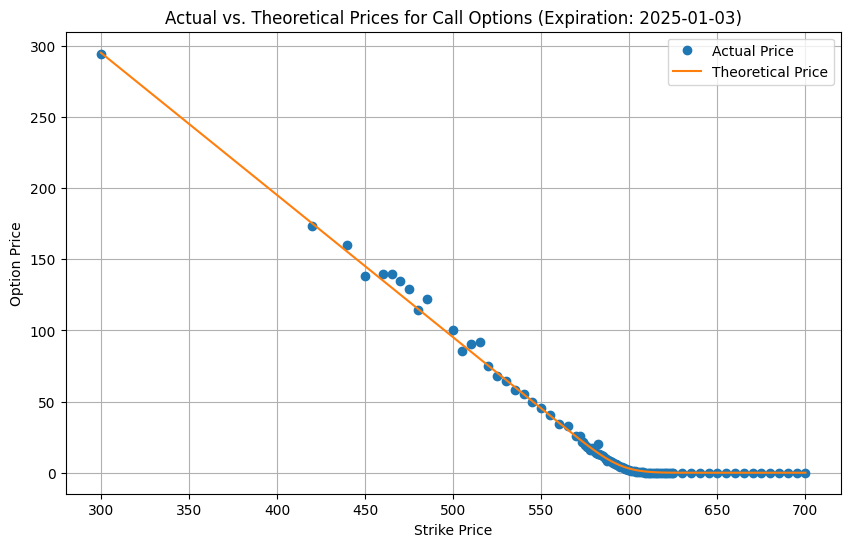

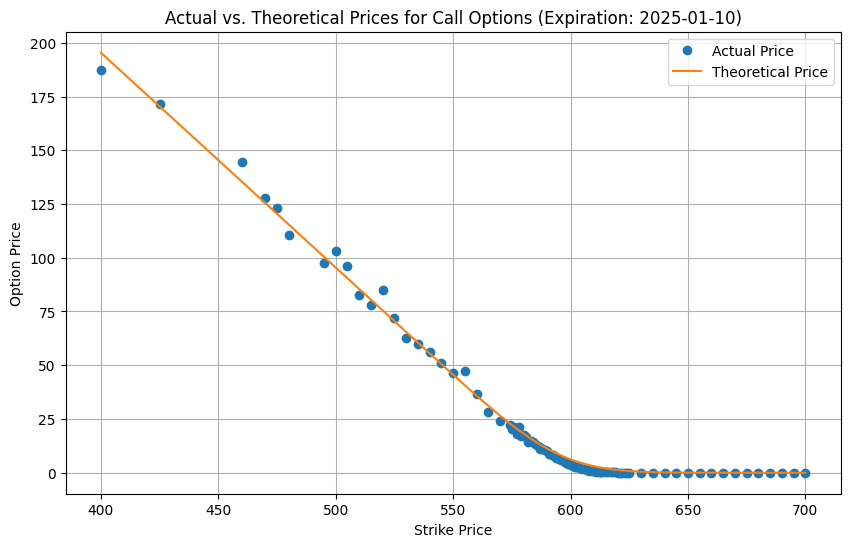

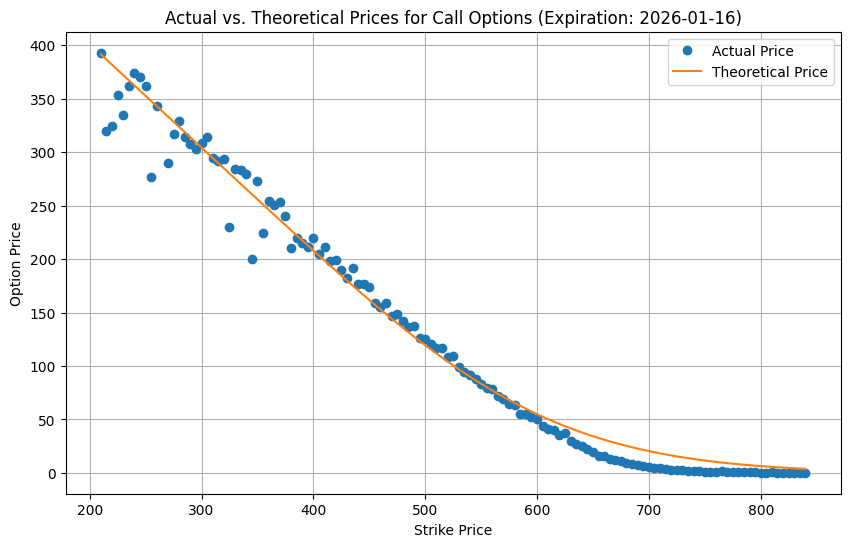

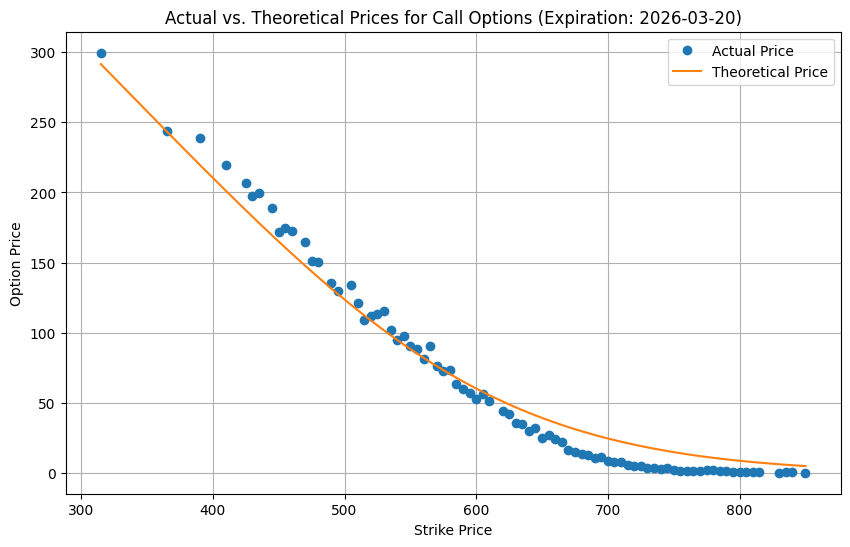

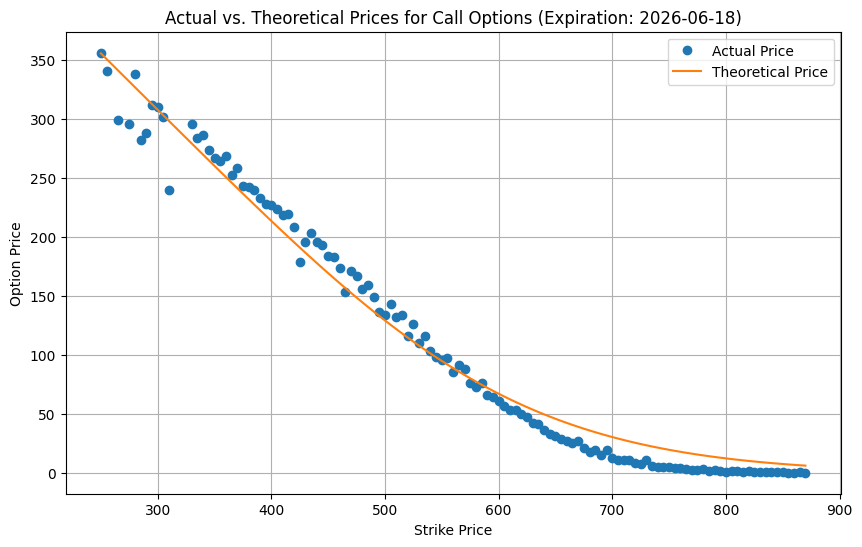

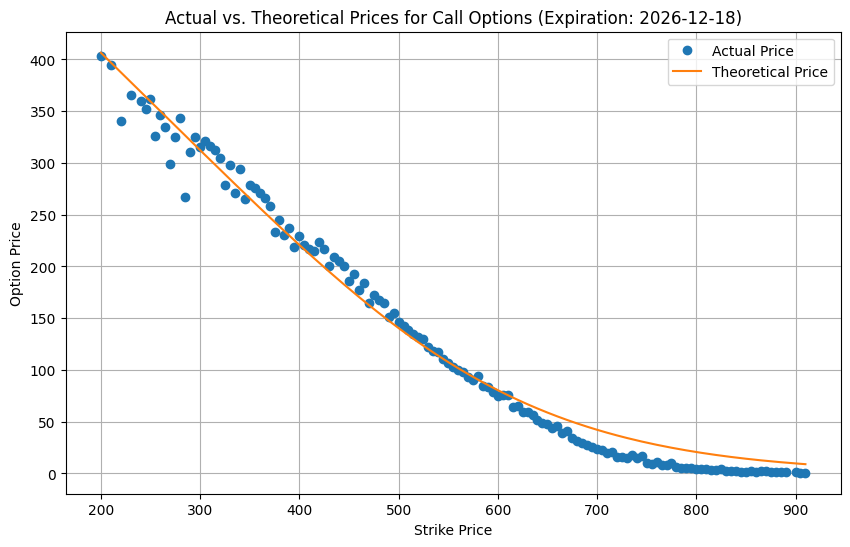

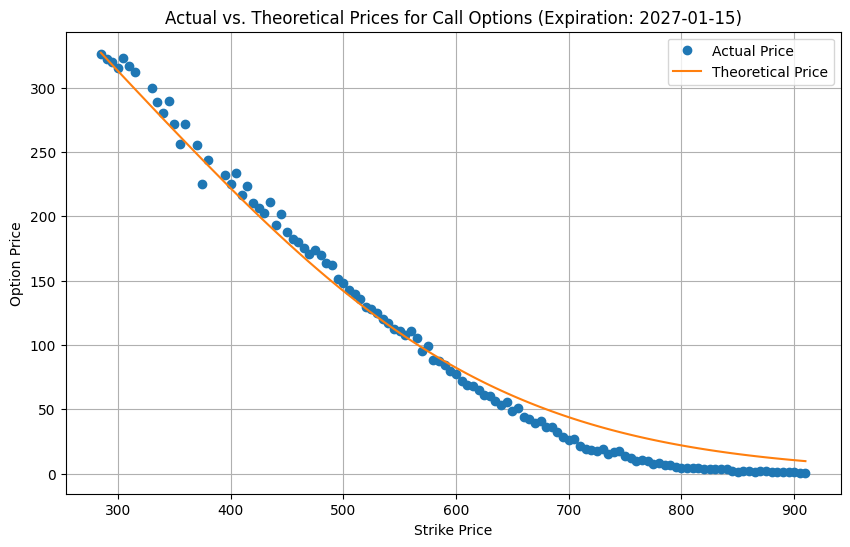

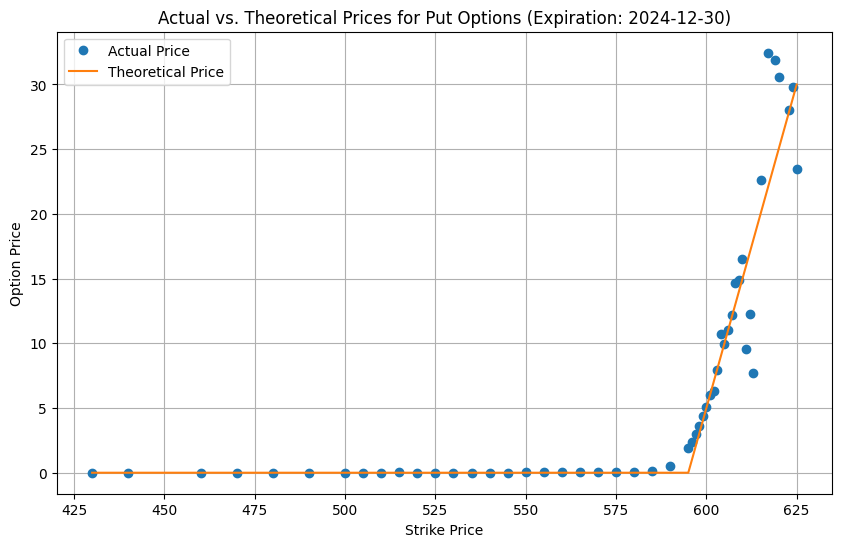

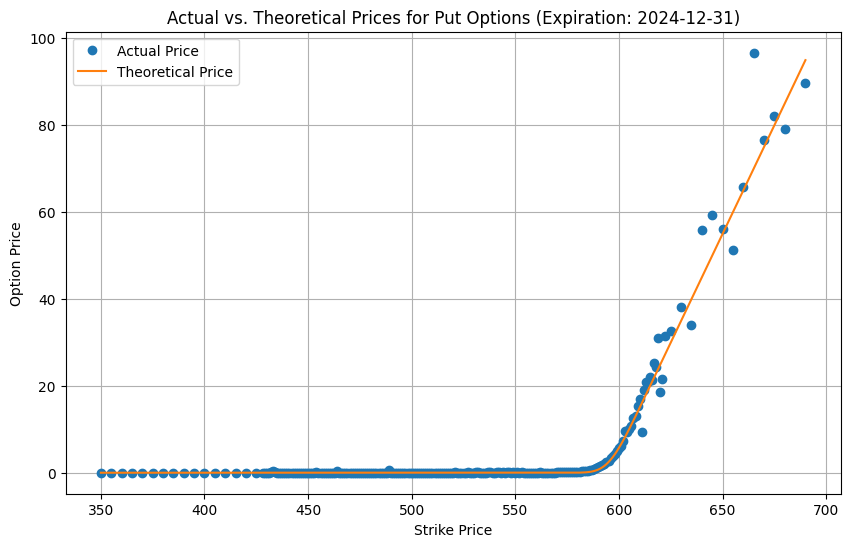

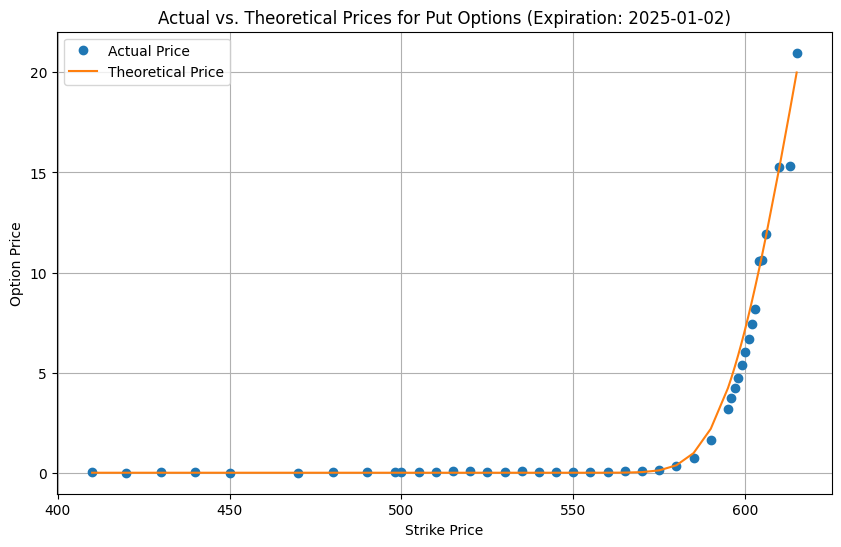

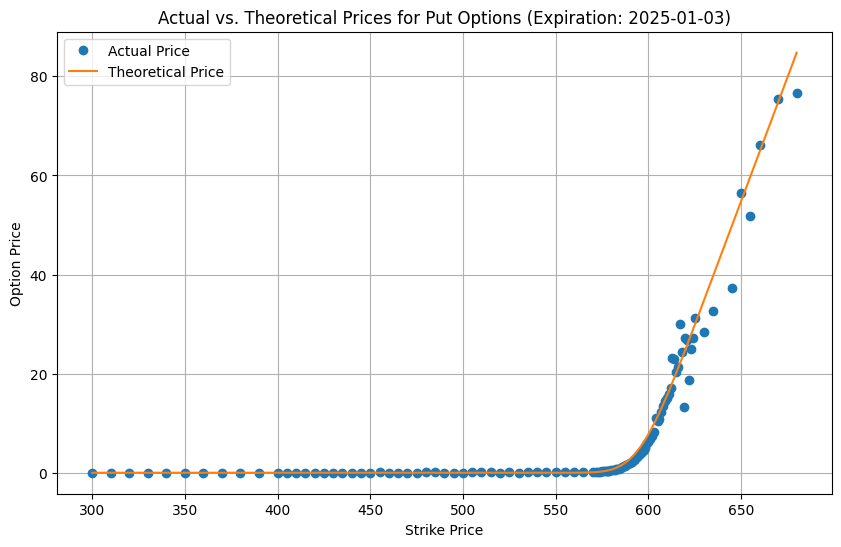

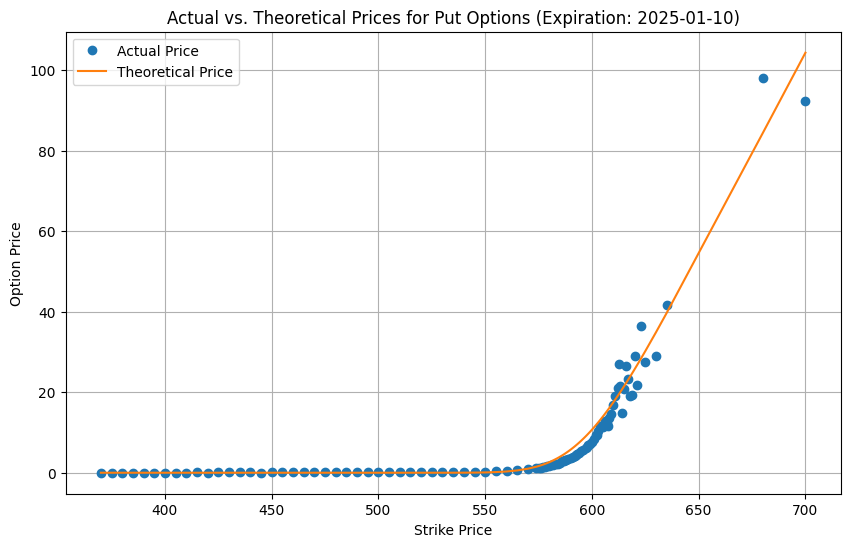

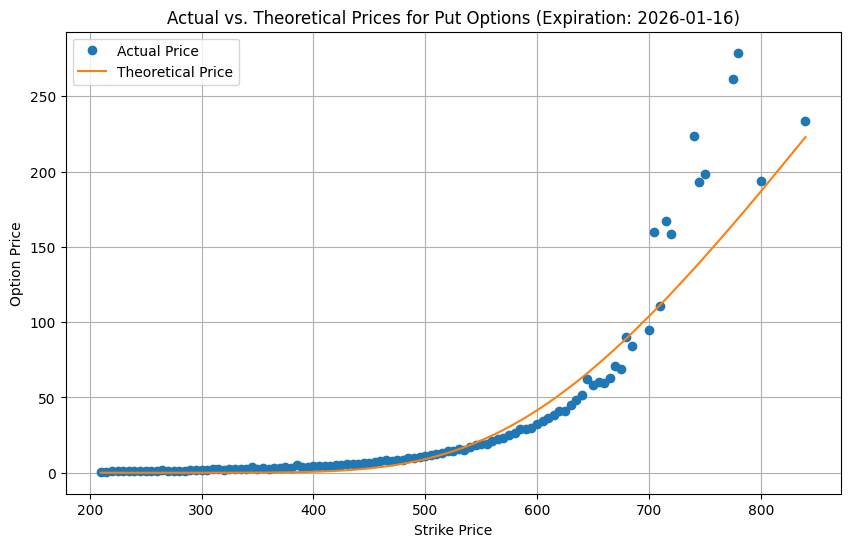

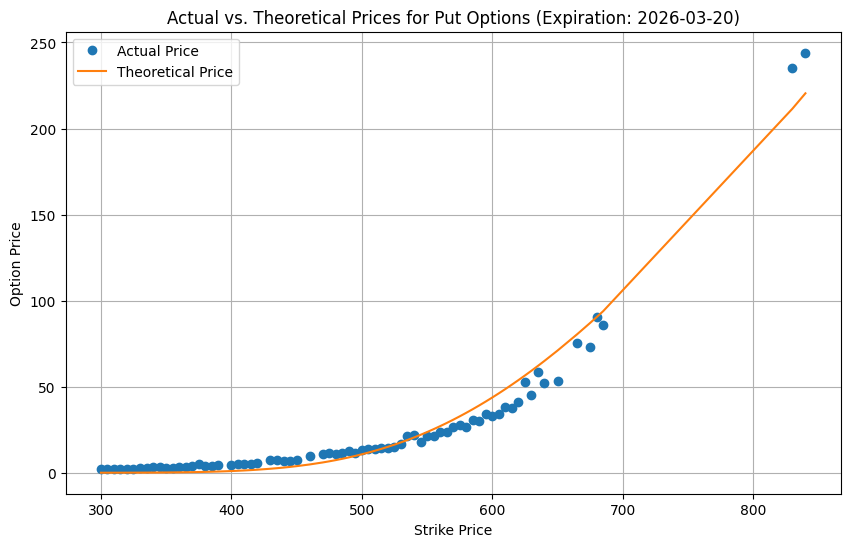

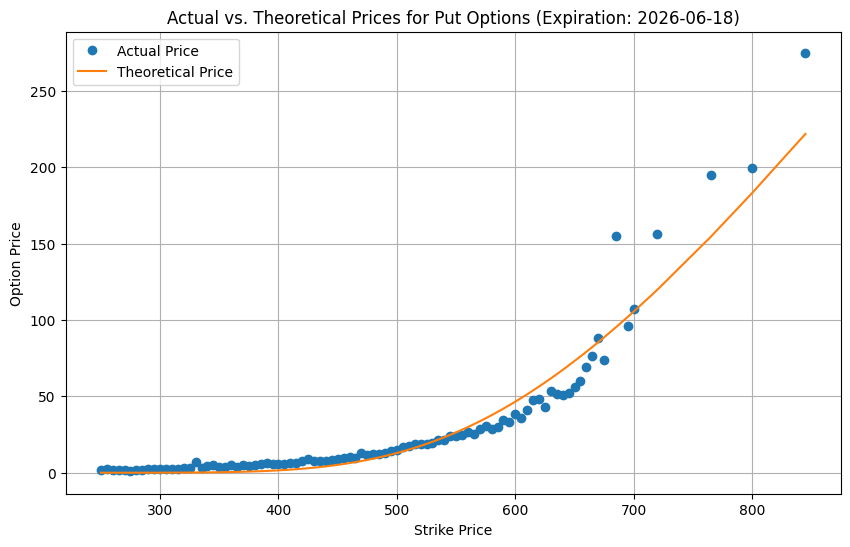

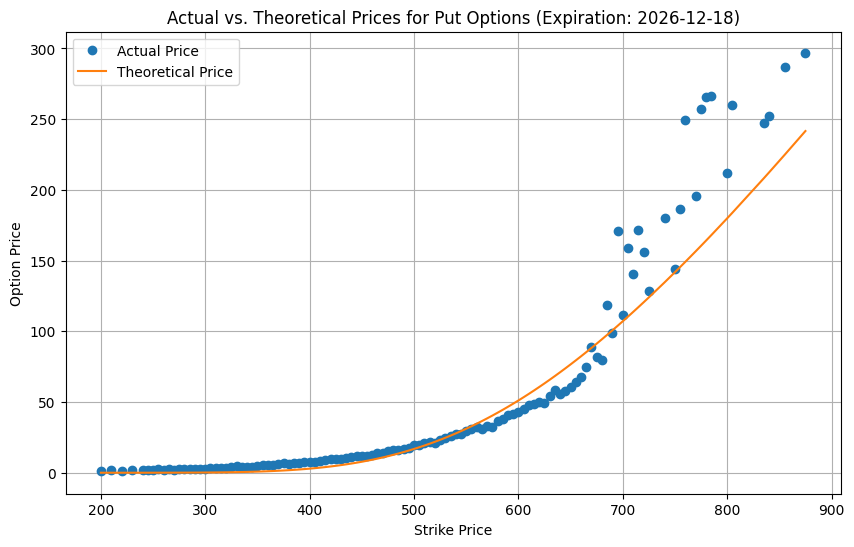

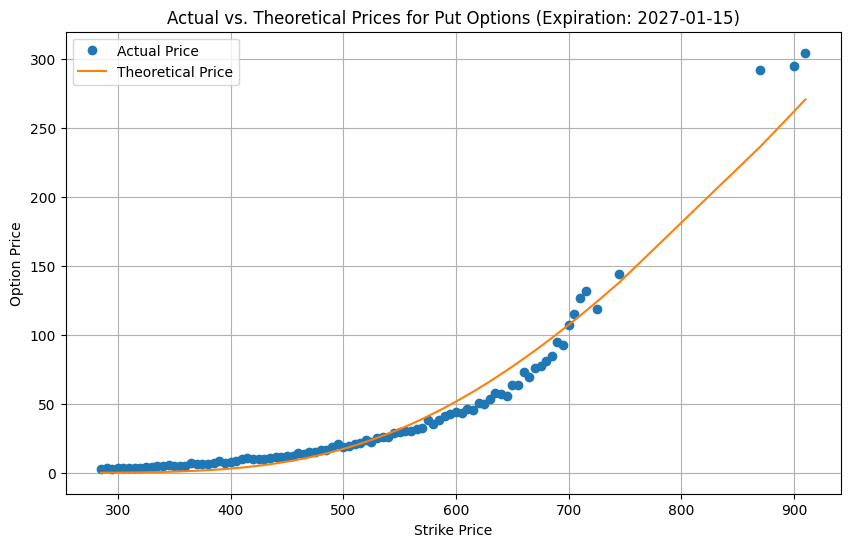

Generated 20 comparison plots for call and put options.


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
import pennylane as qml
from pennylane.templates import AmplitudeEmbedding
from pennylane.optimize import NesterovMomentumOptimizer

# Step 1: Black-Scholes Formula
def black_scholes(S0, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    return price

def greeks(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S0 * sigma * np.sqrt(T))
    vega = S0 * norm.pdf(d1) * np.sqrt(T)
    theta = -(S0 * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    rho = K * T * np.exp(-r * T) * norm.cdf(d2)

    return delta, gamma, vega, theta, rho




# Step 2: Data Acquisition
def fetch_data(ticker, start_date):
    data = yf.Ticker(ticker)
    history = data.history(start=start_date)

    # Fetch option chains for all available expiration dates
    expirations = data.options
    option_chains = []
    for expiration in expirations:
        options = data.option_chain(expiration)
        calls = options.calls
        calls['expiration'] = expiration
        puts = options.puts
        puts['expiration'] = expiration
        option_chains.append((calls, puts))

    return history, option_chains

# Step 3: Data Preprocessing
def preprocess_option_data(option_data, S0, r, sigma):
    option_data['T'] = (pd.to_datetime(option_data['expiration']) - pd.Timestamp.now()).dt.days / 365.0
    option_data['Theoretical_Price'] = option_data.apply(
        lambda row: black_scholes(S0, row['strike'], row['T'], r, sigma, row['type']), axis=1
    )
    option_data[['Delta', 'Gamma', 'Vega', 'Theta', 'Rho']] = option_data.apply(
        lambda row: pd.Series(greeks(S0, row['strike'], row['T'], r, sigma)), axis=1
    )
    return option_data

# Step 4: Plotting
def plot_prices(data, option_type, expiration):
    plt.figure(figsize=(10, 6))
    plt.plot(data['strike'], data['lastPrice'], label="Actual Price", marker='o', linestyle='')
    plt.plot(data['strike'], data['Theoretical_Price'], label="Theoretical Price", linestyle='-')
    plt.xlabel("Strike Price")
    plt.ylabel("Option Price")
    plt.title(f"Actual vs. Theoretical Prices for {option_type.capitalize()} Options (Expiration: {expiration})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Code
if __name__ == "__main__":
    ticker = "SPY"
    start_date = "2023-06-01"

    # Fetch data
    history, option_chains = fetch_data(ticker, start_date)
    S0 = history['Close'].iloc[-1]

    # Process each expiration date
    r = get_risk_free_rate()
    sigma = 0.2  # Assumed constant for simplicity

    all_calls = []
    all_puts = []

    for calls, puts in option_chains:
        calls['type'] = 'call'
        puts['type'] = 'put'

        calls = preprocess_option_data(calls, S0, r, sigma)
        puts = preprocess_option_data(puts, S0, r, sigma)

        all_calls.append(calls)
        all_puts.append(puts)

    # Combine all data
    all_calls = pd.concat(all_calls, ignore_index=True)
    all_puts = pd.concat(all_puts, ignore_index=True)

    # Save results to DataFrame
    combined_df = pd.concat([all_calls, all_puts], ignore_index=True)
    combined_df.to_csv("options_data.csv", index=False)

    # Select data for first 5 and last 5 expiration dates
    first_5_calls = all_calls.groupby('expiration').head(5)
    last_5_calls = all_calls.groupby('expiration').tail(5)
    first_5_puts = all_puts.groupby('expiration').head(5)
    last_5_puts = all_puts.groupby('expiration').tail(5)

    # Plot graphs for selected data
    for i, expiration in enumerate(first_5_calls['expiration'].unique()[:5]):
        data = all_calls[all_calls['expiration'] == expiration]
        plot_prices(data, "call", expiration)

    for i, expiration in enumerate(last_5_calls['expiration'].unique()[-5:]):
        data = all_calls[all_calls['expiration'] == expiration]
        plot_prices(data, "call", expiration)

    for i, expiration in enumerate(first_5_puts['expiration'].unique()[:5]):
        data = all_puts[all_puts['expiration'] == expiration]
        plot_prices(data, "put", expiration)

    for i, expiration in enumerate(last_5_puts['expiration'].unique()[-5:]):
        data = all_puts[all_puts['expiration'] == expiration]
        plot_prices(data, "put", expiration)

    print("Generated 20 comparison plots for call and put options.")
